#



## Orders & Sessions Forecast Model


In [ ]:
#purpose: To create a forecast using VAR model to predict sessions and ecommercr orders

In [1]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

### Importing Data, Data Prep , Inital Data Viz

In [2]:
#loading in csv with data set
df1=pd.read_csv('orders_sessions_var.csv', index_col='date', parse_dates=True);

#ordering in ascending order
df1=df1.sort_values('date', ascending=True)


#let's see what our data looks like
print('\n' + '   orders_sessions_var dataset, shape:' , df1.shape)
df1.head()


   orders_sessions_var dataset, shape: (235, 5)


,order_count,session_count,negative_sessions,positive_sessions,invalid_sessions
date,,,,,
2021-09-01,2619,8555,7946,425,184
2021-09-02,1986,10155,9504,496,155
2021-09-03,1863,10207,9577,456,174
2021-09-04,1448,7812,7411,283,118
2021-09-05,1479,7286,6967,212,107


<AxesSubplot:xlabel='date'>

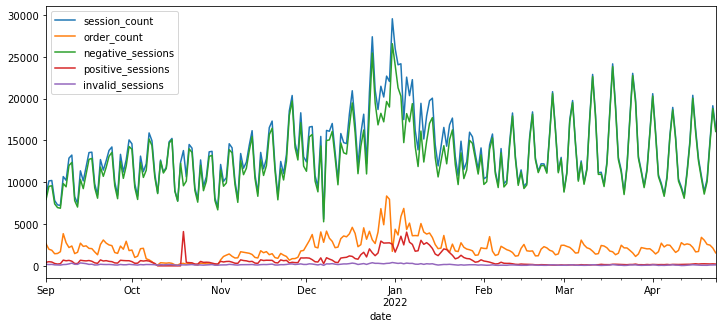

In [3]:
#Let's see what our data looks like

#plotting everything together
df1['session_count'].plot(figsize=(12,5),legend=True)
df1['order_count'].plot(figsize=(12,5), legend=True)
df1['negative_sessions'].plot(figsize=(12,5) ,legend=True)
df1['positive_sessions'].plot(figsize=(12,5) , legend=True)
df1['invalid_sessions'].plot(figsize=(12,5) ,legend=True)


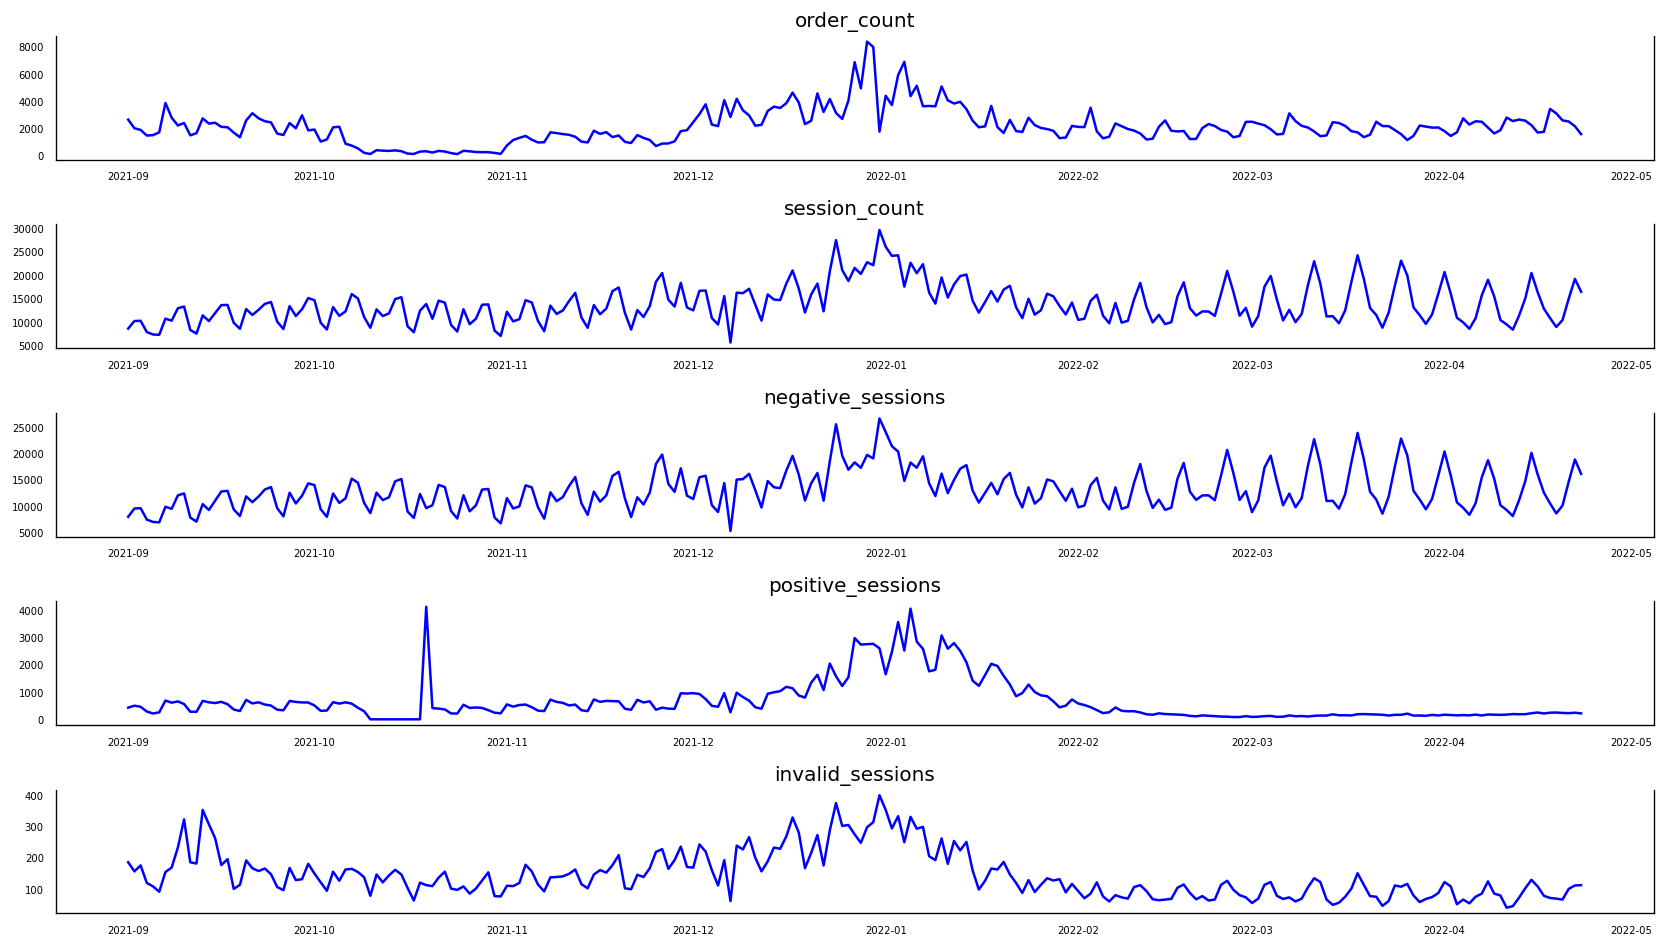

In [4]:
#lets visualize all the variables separately to see if we can see any correlation patterns visually 

#creating subplots with 2 rows and 3 columns which is 6 plots, which is enough for out 5 variables
fig, axes = plt.subplots( nrows=5, ncols=1, dpi=120, figsize=(14,8))
#looping through the variables
for i, ax in enumerate(axes.flatten()):
    data = df1[df1.columns[i]]
    ax.plot(data, color='blue', linewidth=1.5)
    ax.set_title(df1.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    
plt.tight_layout()

### Testing for Stationarity

In [5]:
# Like ARIMA, the VAR model assumes data is stationarity . Non-stationary or trending data can often be transformed 
#to be stationary by usinfg first-differencing or some other method.

# Let's test our data for stationarity  using the Augmented Dickey-Fuller unit root test 
# In particular, we will test the 2 variables we are interested in, which is 'order_count' and 'session_count'

In [6]:
from statsmodels.tsa.stattools import adfuller
#Testing for stationarity


#printing the result object from the adf test
order_adf = adfuller(df1['order_count'])
session_adf = adfuller(df1['session_count'])

print('order_count ADF results' + '\n')
print(order_adf)


print('\n'+'session_count ADF results' + '\n')
print(session_adf)

order_count ADF results

(-2.179602997566245, 0.2137314973978232, 9, 225, {'1%': -3.4597521044060353, '5%': -2.874472927517147, '10%': -2.5736628197530864}, 3503.0089554254764)

session_count ADF results

(-2.565779168795919, 0.10027826783024951, 9, 225, {'1%': -3.4597521044060353, '5%': -2.874472927517147, '10%': -2.5736628197530864}, 3935.707335943337)


In [7]:
# 0th element = Test Statistic, the more negative the better
#1st element = p-value (remeber, we want pvalue < .05)
# the rest show critial values and their respective pvalues

### Data Transformation for Stationarity

In [8]:
# From these results, we can see our pvalue is greater than .05, for both 'order_count' AND 'session_count' 
#so we fail to reject our null hypothesis in BOTH cases
# Meaning, both 'order_count' and 'session_count' are NON-STATIONARY

# To Account for this, We will now preform a transformation on or variables of interest to achieve stationarity m
# There are 3 methods for turning non stationary data into stationary data, which are differencing, transformation, 
#and stat rollups
# We will be attempting the differcing method 

In [9]:
#doing differencing method
df1_diff = pd.DataFrame
df1_diff = df1.diff()


In [10]:
df1_diff=df1_diff.sort_values('date', ascending=True)
df1_diff.head()

,order_count,session_count,negative_sessions,positive_sessions,invalid_sessions
date,,,,,
2021-09-01,NaN,NaN,NaN,NaN,NaN
2021-09-02,-633.0,1600.0,1558.0,71.0,-29.0
2021-09-03,-123.0,52.0,73.0,-40.0,19.0
2021-09-04,-415.0,-2395.0,-2166.0,-173.0,-56.0
2021-09-05,31.0,-526.0,-444.0,-71.0,-11.0


### Testing again for Stationarity after differencing

<AxesSubplot:xlabel='date'>

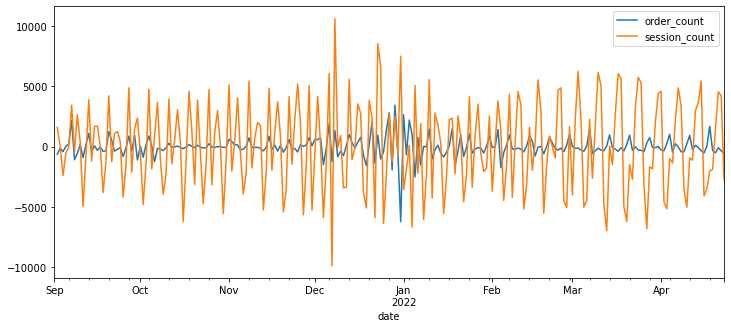

In [11]:
#Let's visualize the differences 

ax1 = df1_diff['order_count'].plot(figsize=(12,5),legend=True)
df1_diff['session_count'].plot(figsize=(12,5),legend=True)

In [12]:
df1_diff=df1_diff.drop(columns=['negative_sessions'])
df1_diff=df1_diff.drop(columns=['positive_sessions'])
df1_diff=df1_diff.drop(columns=['invalid_sessions'])
#
df1_diff=df1_diff.dropna()
df1_diff.head()


,order_count,session_count
date,,
2021-09-02,-633.0,1600.0
2021-09-03,-123.0,52.0
2021-09-04,-415.0,-2395.0
2021-09-05,31.0,-526.0
2021-09-06,211.0,-53.0


In [13]:
#Now let's test the differences again using the ADF test

orderdiff_adf = adfuller(df1_diff['order_count'])
sessiondiff_adf = adfuller(df1_diff['session_count'])

print('order_count ADF results' + '\n')
print(orderdiff_adf)


print('\n'+'session_count ADF results' + '\n')
print(sessiondiff_adf)

order_count ADF results

(-5.014682549222159, 2.075516550764158e-05, 9, 224, {'1%': -3.459884913337196, '5%': -2.8745310704320794, '10%': -2.573693840082908}, 3489.363470680907)

session_count ADF results

(-5.250013463710772, 6.943992914742064e-06, 7, 226, {'1%': -3.4596204846395824, '5%': -2.8744153028455948, '10%': -2.5736320761218576}, 3923.1293759084774)


### Train & Test

In [14]:
from statsmodels.tsa.api import VAR


#Lets break the data into training and testing sets into 80/20
print(df1_diff.shape)





(234, 2)


In [15]:
train_df=df1_diff[:186]
test_df=df1_diff[48:]

In [16]:
train_df.head()

,order_count,session_count
date,,
2021-09-02,-633.0,1600.0
2021-09-03,-123.0,52.0
2021-09-04,-415.0,-2395.0
2021-09-05,31.0,-526.0
2021-09-06,211.0,-53.0


In [17]:
model=VAR(train_df)

sorted_order = model.select_order()
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        30.04       30.08   1.114e+13       30.06
1        29.96       30.07   1.025e+13       30.00
2        29.58       29.76   7.026e+12       29.65
3        29.55       29.81   6.841e+12       29.66
4        29.28       29.61   5.227e+12       29.42
5        29.15       29.56   4.591e+12       29.32
6        28.74       29.21   3.028e+12       28.93
7        28.66       29.21   2.794e+12       28.88
8        28.56      29.18*   2.541e+12      28.81*
9       28.56*       29.25  2.527e+12*       28.84
10       28.58       29.35   2.602e+12       28.90
11       28.62       29.46   2.700e+12       28.96
12       28.63       29.54   2.723e+12       29.00
13       28.63       29.62   2.737e+12       29.03
14       28.64       29.70   2.754e+12       29.07
--------------------------------------------------


/Users/belmarieponciano/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [19]:
res = model.fit(9)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 07, Jun, 2022
Time:                     14:58:40
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    29.2006
Nobs:                     177.000    HQIC:                   28.7953
Log likelihood:          -2988.21    FPE:                2.43363e+12
AIC:                      28.5187    Det(Omega_mle):     1.98468e+12
--------------------------------------------------------------------
Results for equation order_count
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                  -17.912799        56.048094           -0.320           0.749
L1.order_count          -0.563615         0.081154           -6.945           0.000
L1.session_count        -0.008759         

In [20]:
## compaire mean squre eoo

### Plotting

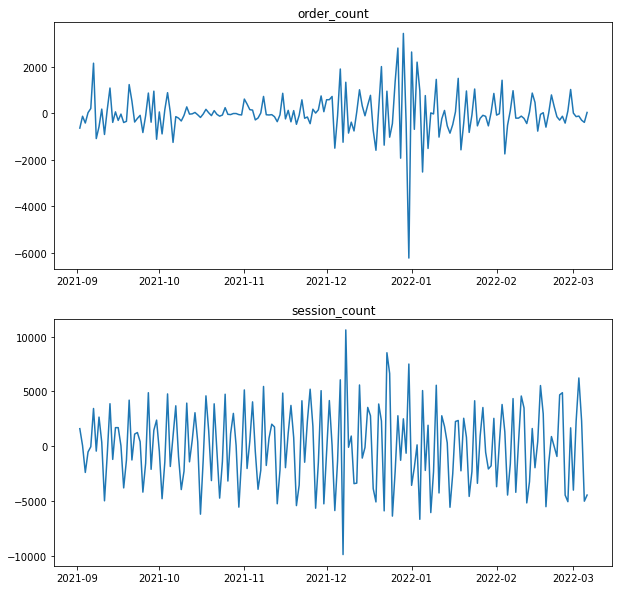

In [21]:
res.plot();

### Forecasting

In [86]:
# we are going to define how many steps ahead to forecast 
#going to pass an array with p,lag order , k 

num_days_to_predict = 15

,order_diff,session_diff
date,,
2021-09-02,-633.0,1600.0
2021-09-03,-123.0,52.0
2021-09-04,-415.0,-2395.0
2021-09-05,31.0,-526.0
2021-09-06,211.0,-53.0
...,...,...
2022-04-19,-333.0,-1887.0
2022-04-20,-510.0,1466.0
2022-04-21,-86.0,4549.0


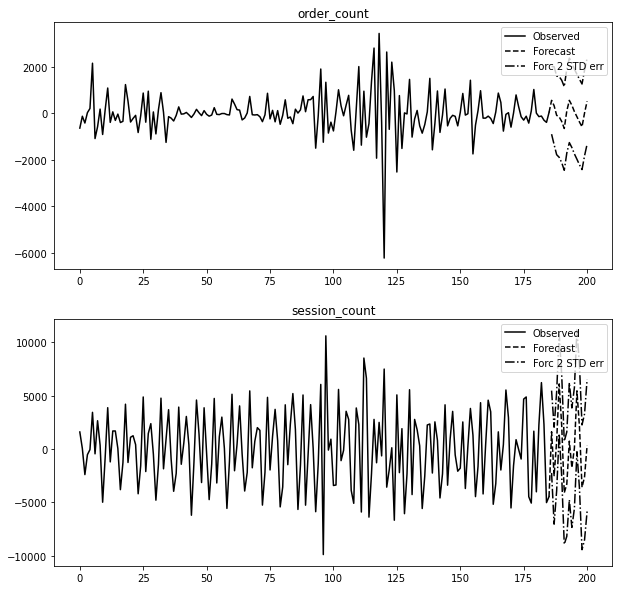

In [87]:
forecast_res = res.forecast(df1_diff.values[1:], num_days_to_predict)
res.plot_forecast(num_days_to_predict)
df1_diff

## Set up DataFrame with Forecasted Data

In [88]:
indx = pd.date_range('4/24/2022', periods = num_days_to_predict, freq='D')
forecast_df = pd.DataFrame(forecast_res,index=indx, 
                           columns=['f-order_count','f-session_count'])
forecast_df

,f-order_count,f-session_count
2022-04-24,136.660761,-3088.395713
2022-04-25,481.095957,-1105.347576
2022-04-26,493.803800,-1554.764918
2022-04-27,160.846465,154.665934
2022-04-28,-250.711825,3742.723820
2022-04-29,-318.930655,3537.513204
2022-04-30,-483.983732,-1931.089120
2022-05-01,-149.533951,-2846.782634
2022-05-02,406.852863,-718.337485
2022-05-03,465.777465,-1232.349888


## Tranforming Differenced Data Back to Original Form 

In [95]:
#example on df manipulation

ex_df = pd.DataFrame({'A': np.random.randint(0,10,5)})
ex_df['B'] = ex_df['A'].diff()
ex_df
x , x_diff = ex_df['A'].iloc[0], ex_df['B'].iloc[1:]

ex_df['C'] = np.r_[x,x_diff].cumsum().astype(float)
ex_df

,A,B,C
0,3,NaN,3.0
1,2,-1.0,2.0
2,0,-2.0,0.0
3,9,9.0,9.0
4,3,-6.0,3.0


In [96]:
df1

,order_count,session_count,negative_sessions,positive_sessions,invalid_sessions
date,,,,,
2021-09-01,2619,8555,7946,425,184
2021-09-02,1986,10155,9504,496,155
2021-09-03,1863,10207,9577,456,174
2021-09-04,1448,7812,7411,283,118
2021-09-05,1479,7286,6967,212,107
...,...,...,...,...,...
2022-04-19,3075,8893,8579,246,68
2022-04-20,2565,10359,10062,232,65
2022-04-21,2479,14908,14585,224,99


df1_diff

In [97]:
df1_diff


,order_diff,session_diff
date,,
2021-09-02,-633.0,1600.0
2021-09-03,-123.0,52.0
2021-09-04,-415.0,-2395.0
2021-09-05,31.0,-526.0
2021-09-06,211.0,-53.0
...,...,...
2022-04-19,-333.0,-1887.0
2022-04-20,-510.0,1466.0
2022-04-21,-86.0,4549.0


In [98]:
df1_diff.rename(columns={'order_count': 'order_diff', 'session_count': 'session_diff'}, inplace=True)

In [99]:
df1_diff

,order_diff,session_diff
date,,
2021-09-02,-633.0,1600.0
2021-09-03,-123.0,52.0
2021-09-04,-415.0,-2395.0
2021-09-05,31.0,-526.0
2021-09-06,211.0,-53.0
...,...,...
2022-04-19,-333.0,-1887.0
2022-04-20,-510.0,1466.0
2022-04-21,-86.0,4549.0


In [100]:
frames = [df1,df1_diff,forecast_df]
final_df = pd.concat(frames, axis=1)
final_df

,order_count,session_count,negative_sessions,positive_sessions,invalid_sessions,order_diff,session_diff,f-order_count,f-session_count
2021-09-01,2619.0,8555.0,7946.0,425.0,184.0,NaN,NaN,NaN,NaN
2021-09-02,1986.0,10155.0,9504.0,496.0,155.0,-633.0,1600.0,NaN,NaN
2021-09-03,1863.0,10207.0,9577.0,456.0,174.0,-123.0,52.0,NaN,NaN
2021-09-04,1448.0,7812.0,7411.0,283.0,118.0,-415.0,-2395.0,NaN,NaN
2021-09-05,1479.0,7286.0,6967.0,212.0,107.0,31.0,-526.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-05-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.522510,-149.017566
2022-05-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-27.423366,3318.676860
2022-05-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-311.392178,2892.378568
2022-05-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-502.502755,-1501.029185


In [130]:
#for i == nan in order count:
    #add ordercount[i-1] + f_order_count[i]
    
#for i == nan in session count:
    #add sessioncount[i-1] + f_session_count[i]  

for index, val in enumerate(final_df['order_count']):
#     print(pd.isnull(val))
    if pd.isnull(val):
        final_df['order_count'][index] = final_df['order_count'][index-1] + final_df['f-order_count'][index]


for index, val in enumerate(final_df['session_count']):
#     print(pd.isnull(val))
    if pd.isnull(val):
        final_df['session_count'][index] = final_df['session_count'][index-1] + final_df['f-session_count'][index]
                 

#         print(final_df['order_count'][index])
# for index, val in df3['session_count']:
#     if val=='NaN':
#         df['session_count'] = df['session_count'][index-1] + df['f-session_count']
final_df[-15:]

,order_count,session_count,negative_sessions,positive_sessions,invalid_sessions,order_diff,session_diff,f-order_count,f-session_count
2022-04-24,1690.660761,13303.604287,NaN,NaN,NaN,NaN,NaN,136.660761,-3088.395713
2022-04-25,2171.756718,12198.256711,NaN,NaN,NaN,NaN,NaN,481.095957,-1105.347576
2022-04-26,2665.560519,10643.491793,NaN,NaN,NaN,NaN,NaN,493.803800,-1554.764918
2022-04-27,2826.406984,10798.157727,NaN,NaN,NaN,NaN,NaN,160.846465,154.665934
2022-04-28,2575.695159,14540.881548,NaN,NaN,NaN,NaN,NaN,-250.711825,3742.723820
2022-04-29,2256.764504,18078.394751,NaN,NaN,NaN,NaN,NaN,-318.930655,3537.513204
2022-04-30,1772.780772,16147.305631,NaN,NaN,NaN,NaN,NaN,-483.983732,-1931.089120
2022-05-01,1623.246821,13300.522998,NaN,NaN,NaN,NaN,NaN,-149.533951,-2846.782634
2022-05-02,2030.099684,12582.185513,NaN,NaN,NaN,NaN,NaN,406.852863,-718.337485
2022-05-03,2495.877149,11349.835625,NaN,NaN,NaN,NaN,NaN,465.777465,-1232.349888


<AxesSubplot:>

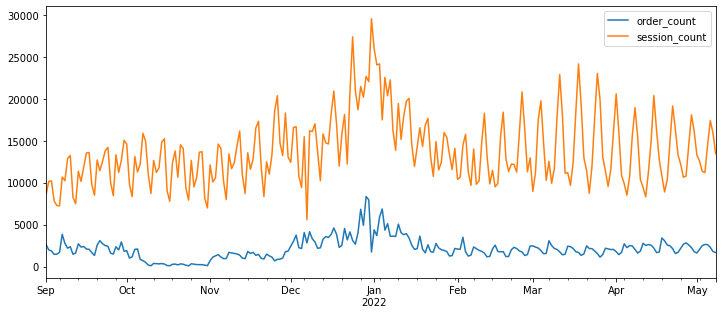

In [102]:

#plotting everything together
final_df['order_count'].plot(figsize=(12,5),legend=True)
final_df['session_count'].plot(figsize=(12,5), legend=True)


In [105]:
forecast_viz_df = pd.DataFrame(final_df,
                           columns=['session_count','order_count'])


In [113]:
forecast_viz_df[-50:]

,session_count,order_count
2022-03-20,12948.000000,1508.000000
2022-03-21,11445.000000,2465.000000
2022-03-22,8738.000000,2150.000000
2022-03-23,11949.000000,2139.000000
2022-03-24,17699.000000,1856.000000
2022-03-25,23016.000000,1552.000000
2022-03-26,19892.000000,1122.000000
2022-03-27,13068.000000,1423.000000
2022-03-28,11395.000000,2185.000000
2022-03-29,9550.000000,2110.000000


# Plotting Forecasted values

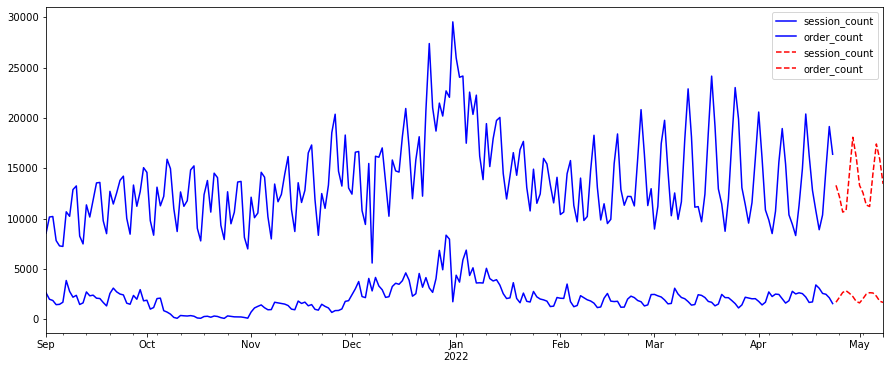

In [131]:

ax = forecast_viz_df.iloc[:-15,].plot(ls="-", color="b")
forecast_viz_df.iloc[-15:,:].plot(ls="--", color="r", figsize=(15,6), ax=ax)
plt.show()